In [1]:
import contextlib
import datasets
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet, words
from nltk.stem import WordNetLemmatizer
import mmh3
import numpy as np
from bitarray import bitarray
import contextlib
import numpy as np
import time
import string
import nltk
import json

import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

lemmatize = lambda word: nlp(str(word))[0].lemma_

nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = set(stopwords.words('english'))

# data = datasets.load_dataset("wikipedia", "20220301.en")
# data = datasets.load_dataset("bookcorpus/bookcorpus")
# data = data['train']
data = []
for i in range (1, 1731):
    with contextlib.suppress(FileNotFoundError):
        with open(f'data/fairy_tales/{i}.txt', 'rb') as f:
            data.append(f.read())

/Users/Yourui/Documents/bloom-filters/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yourui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def tokenize(sentence):
    tokenized = nlp(sentence.translate(str.maketrans('', '', string.punctuation)))
    return [token.lemma_ for token in tokenized if token.lemma_ not in en_stopwords and wordnet.synsets(token.lemma_)]

In [3]:
data[0]

b'THE LONG WAPPERS, AND THEIR TRICKS\r\n\r\n\r\nIn his rambles in Belgium, the story-teller found no parts of any city\r\nin the land equal in interest to those of old Antwerp. If he sauntered\r\ndown toward evening, into the narrow streets and through the stone\r\ngateway, blackened with age, under which the great Charles V. rode, the\r\nfairies and funny folks seemed almost as near to him as the figures in\r\nreal history. Here, many a prince or princess made their \xe2\x80\x9cjoyous\r\nentry,\xe2\x80\x9d into the wonderful city of Brabo, the boy hero, who slew the\r\ncruel giant Antigonus and cut off his cruel hands.\r\n\r\nHere, the story-teller noticed a great many images of the Virgin Mary;\r\nwhereas, in the newer parts of the city, there were few or none. They\r\nwere usually set in the house corners, where two streets came together.\r\nInquiring into the reason of this, he discovered a new kind of Belgian\r\nfairy, the Wapper, famous for his long legs and funny tricks. Here we

In [4]:
def hash_token(token, bits):
    representation = np.zeros(bits)
    
    for i in range(3):
        digest = mmh3.hash(token, i) % bits
        representation[digest] = 1
    return representation

In [5]:
with open('data/fairytales_full_tf-idf.json', 'r') as f:
    tf_idfs = json.load(f)

In [6]:
def get_bloom_filters(word, n_occurrences=10000, deltas=None, bits=32):
    if deltas is None:
        deltas = [-4, -3, -2, -1, 1, 2, 3, 4]
    word = lemmatize(word) # using the old lemmatizer, shouldn't necessarily be an issue right now

    return_data = []
    occurrences = 0

    for i, row in enumerate(data):
        try:
            sentences = sent_tokenize(row.decode('cp1252').lower())
        except UnicodeDecodeError:
            sentences = sent_tokenize(row.decode('utf8').lower())

        # sentences = sent_tokenize(row['text'].lower())

        for sentence in sentences:
            if word in sentence:
                tokenized = tokenize(sentence)
                indices = [i for i, x in enumerate(tokenized) if x == word]
                for index in indices:
                    representation = np.zeros(bits)

                    for delta in deltas:
                        if index + delta < 0:
                            continue
                        with contextlib.suppress(IndexError):
                            adjacent_word = tokenized[index + delta]
                            try:
                                # tf_idf = tf_idfs[word][adjacent_word]['tf-idf']
                                tf_idf = tf_idfs[word][adjacent_word]
                            except KeyError:
                                tf_idf = 0
                            representation += np.array(list(hash_token(adjacent_word, bits))) * tf_idf
                            # representation += np.array(list(hash_token(adjacent_word, bits))) 

                    return_data.append(list(representation))
                    occurrences += 1

                    if n_occurrences and occurrences >= n_occurrences:
                        return return_data

        if i % 10 == 0:
            print(f'"{word}", {i}th row processed, {occurrences}/{n_occurrences} occurrences')

    return return_data

In [7]:
# keep only the most frequently occurring words next to the target word (ex: 1000+ occurrences) + aggregate those words + collect data
    # Table 1: Most frequent words
    # Table 2: Most frequent words with count vectors
# test discarding bits with high variance values

In [8]:
def store_encoding(word, fname, args):
    frequencies = get_bloom_filters(word, **args)
    
    with open(fname, 'r') as f:
        encodings = json.load(f)
    encodings[word] = frequencies
    with open(fname, 'w') as f:
        json.dump(encodings, f, indent=4)

In [9]:
l = ["man","woman","king","queen"]

for value in l:
    store_encoding(value, 'data/fairytales_vectors.json', {'n_occurrences':None, 'deltas': [-4, -3, -2, -1, 1, 2, 3, 4], 'bits':10})

"man", 0th row processed, 2/None occurrences
"man", 10th row processed, 32/None occurrences
"man", 20th row processed, 58/None occurrences
"man", 30th row processed, 156/None occurrences
"man", 40th row processed, 252/None occurrences
"man", 50th row processed, 300/None occurrences
"man", 60th row processed, 355/None occurrences
"man", 70th row processed, 448/None occurrences
"man", 80th row processed, 482/None occurrences
"man", 90th row processed, 498/None occurrences
"man", 100th row processed, 512/None occurrences
"man", 110th row processed, 548/None occurrences
"man", 120th row processed, 589/None occurrences
"man", 130th row processed, 624/None occurrences
"man", 140th row processed, 650/None occurrences
"man", 150th row processed, 813/None occurrences
"man", 160th row processed, 880/None occurrences
"man", 170th row processed, 978/None occurrences
"man", 180th row processed, 1028/None occurrences
"man", 190th row processed, 1075/None occurrences
"man", 200th row processed, 1117/

In [10]:
with open('data/fairytales_full_unweighted_vectors.json', 'r') as f:
    data = json.load(f)

# removes newlines in lists for readability
import re
def repl_func(match: re.Match):
    return " ".join(match.group().split())
json_str = json.dumps(data, indent=4)
json_str = re.sub(r"(?<=\[)[^\[\]]+(?=])", repl_func, json_str)

with open('data/fairytales_full_unweighted_vectors.json', 'w') as f:
    f.write(json_str)

In [11]:
data

{'man': [[0.0,
   0.034825878121064746,
   0.12113350297017828,
   0.038978757457566196,
   0.0,
   0.08215474551261208,
   0.08215474551261208,
   0.0041528793365014464,
   0.0,
   0.0],
  [0.006881516669261968,
   0.0020571300936973393,
   0.006316338222685896,
   0.04951280655781567,
   0.006316338222685896,
   0.0,
   0.008373468316383236,
   0.04951280655781567,
   0.004824386575564628,
   0.004824386575564628],
  [0.01563442842723137,
   0.0,
   0.0,
   0.08700046597135849,
   0.1157056364382664,
   0.0,
   0.013070742039676534,
   0.14849782432475594,
   0.24647976603922717,
   0.1641322527519873],
  [0.0,
   0.0,
   0.002072078686096497,
   0.0372138528873751,
   0.010990044073158269,
   0.0372138528873751,
   0.008917965387061771,
   0.14849782432475594,
   0.1594878683979142,
   0.14849782432475594],
  [0.0,
   0.024740772393658905,
   0.0,
   0.0,
   0.0,
   0.0021261406796796124,
   0.0,
   0.17111245603873523,
   0.17323859671841485,
   0.14849782432475594],
  [0.034306682

In [12]:
points = []
for word in data.keys():
    points.extend([word, np.array(row)] for row in data[word])

In [13]:
import random
random.shuffle(points)

In [14]:

labels = np.array([point[0] for point in points])
lookup, clabels = np.unique(labels, return_inverse=True)
vectors = np.array([point[1] for point in points])

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features_pca = pca.fit_transform(vectors)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_23074/2916236344.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 4)


<Figure size 500x500 with 0 Axes>

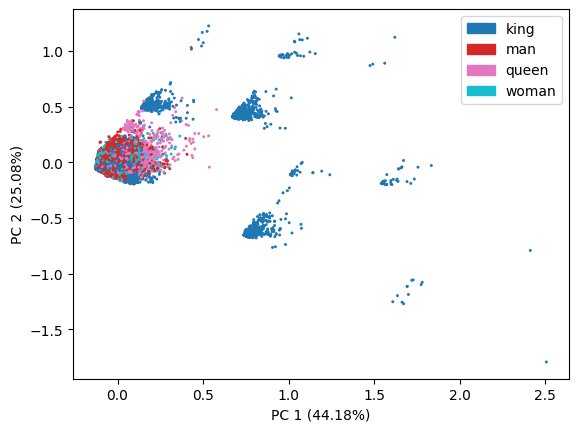

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = plt.cm.get_cmap('tab10', 4)

plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.scatter(features_pca[:,0], features_pca[:,1], c=clabels, cmap='tab10', s=5, marker='.')

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

plt.legend([mpatches.Patch(color=cmap(b)) for b in range(4)], lookup)

plt.savefig('pca.png', dpi=300)
plt.show()